<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: старший преподаватель Факультета Компьютерных Наук НИУ ВШЭ <br> Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Занятие 10. Временные ряды. Блендинг моделей.</center>
## Часть 2.  Блендинг случайного леса и градиентного бустинга для набора данных по кредитному скорингу

[Соревнование](https://inclass.kaggle.com/c/beeline-credit-scoring-competition). Цель - спрогнозировать, что человек просрочит выплаты по кредиту на 3 месяца и более (целевой признак - Delinquent90).

Признаки клиентов банка:

- Age - возраст (вещественный)
- Income - месячный доход (вещественный)
- BalanceToCreditLimit - отношение баланса на кредитной карте к лимиту по кредиту (вещественный)
- DIR - Debt-to-income Ratio (вещественный)
- NumLoans - число заемов и кредитных линий
- NumRealEstateLoans - число ипотек и заемов, связанных с недвижимостью (натуральное число)
- NumDependents - число членов семьи, которых содержит клиент, исключая самого клиента (натуральное число)
- Num30-59Delinquencies - число просрочек выплат по кредиту от 30 до 59 дней (натуральное число)
- Num60-89Delinquencies - число просрочек выплат по кредиту от 60 до 89 дней (натуральное число)
- Delinquent90 - были ли просрочки выплат по кредиту более 90 дней (бинарный) - имеется только в обучающей выборке

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
import sys
sys.path.append('../../scripts/')
from log_progress import log_progress
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Считываем данные.**

In [3]:
train_df = pd.read_csv('../../data/credit_scoring_train.csv', 
                       index_col='client_id')
test_df = pd.read_csv('../../data/credit_scoring_test.csv', 
                      index_col='client_id')

In [4]:
y = train_df['Delinquent90']
train_df.drop('Delinquent90', axis=1, inplace=True)

In [5]:
train_df.head()

,DIR,Age,NumLoans,NumRealEstateLoans,NumDependents,Num30-59Delinquencies,Num60-89Delinquencies,Income,BalanceToCreditLimit
client_id,,,,,,,,,
0,0.496289,49.1,13,0,0.0,2,0,5298.360639,0.387028
1,0.433567,48.0,9,2,2.0,1,0,6008.056256,0.234679
2,2206.731199,55.5,21,1,NaN,1,0,NaN,0.348227
3,886.132793,55.3,3,0,0.0,0,0,NaN,0.971930
4,0.000000,52.3,1,0,0.0,0,0,2504.613105,1.004350


**Посчитаем, число пропусков в каждом признаке.**

In [6]:
for col in train_df.columns:
    print("{0}, num. NA's: {1}".format(col, pd.isnull(train_df[col]).sum()))

DIR, num. NA's: 0
Age, num. NA's: 0
NumLoans, num. NA's: 0
NumRealEstateLoans, num. NA's: 0
NumDependents, num. NA's: 1916
Num30-59Delinquencies, num. NA's: 0
Num60-89Delinquencies, num. NA's: 0
Income, num. NA's: 14847
BalanceToCreditLimit, num. NA's: 0


In [7]:
for col in test_df.columns:
    print("{0}, num. NA's: {1}".format(col, pd.isnull(test_df[col]).sum()))

DIR, num. NA's: 0
Age, num. NA's: 0
NumLoans, num. NA's: 0
NumRealEstateLoans, num. NA's: 0
NumDependents, num. NA's: 2008
Num30-59Delinquencies, num. NA's: 0
Num60-89Delinquencies, num. NA's: 0
Income, num. NA's: 14884
BalanceToCreditLimit, num. NA's: 0


**Заменим пропуски медианными значениями.**

In [8]:
train_df['NumDependents'].fillna(train_df['NumDependents'].median(), inplace=True)
train_df['Income'].fillna(train_df['Income'].median(), inplace=True)
test_df['NumDependents'].fillna(test_df['NumDependents'].median(), inplace=True)
test_df['Income'].fillna(test_df['Income'].median(), inplace=True)

### Построение признаков

**Теперь будем создавать новые признаки. Для них заведем копию обучающей выборки. Xgboost будем обучать на исходных данных, случайный лес - на новых.**

In [9]:
train_df_fe, test_df_fe = train_df.copy(), test_df.copy()

**Запомним индексы и объединим выборки, чтоб упростить построение признаков.**

In [10]:
train_df_fe_idx, test_df_fe_idx = train_df_fe.index, test_df_fe.index
train_test = pd.concat([train_df_fe, test_df_fe])

In [11]:
train_test['UnknownNumDependents'] = pd.isnull(train_test['NumDependents']).\
                                                                astype('int')
train_test['NoDependents'] = (train_test['NumDependents'] == 0).astype('int')
train_test['NumDependents'].fillna(0, inplace=True)

train_test['UnknownIncome'] = pd.isnull(train_test['Income']).astype('int')
train_test['ZeroIncome'] = (train_test['Income'] == 0).astype('int')
train_test['Income'].fillna(0, inplace=True)

train_test['ZeroBalanceToCreditLimit'] = (train_test['BalanceToCreditLimit'] 
                                          == 0).astype('int')

train_test['OutBalanceToCreditLimit'] = (train_test['BalanceToCreditLimit'] >
                                         train_test['BalanceToCreditLimit'].\
                                         quantile(0.99)).astype('int')
    
train_test['NumRevolvingLoans'] =  train_test['NumLoans'] - \
                                    train_test['NumRealEstateLoans']
train_test['HasRevolvingLoans'] = (train_test['NumRevolvingLoans'] 
                                   > 0).astype('int')
train_test['HasRealEstateLoans'] = (train_test['NumRealEstateLoans'] 
                                    > 0).astype('int')
train_test['ManyRealEstateLoans'] = (train_test['NumRealEstateLoans'] 
                                     > 2).astype('int')
train_test['RevTORealEstateLoans'] = train_test['NumRevolvingLoans'] \
                                    / (1 + train_test['NumRealEstateLoans'])

train_test['DIRover33'] = (train_test['DIR'] > 0.33).astype('int')
train_test['DIRover43'] = (train_test['DIR'] > 0.43).astype('int')

                           
train_test['Zero30-59Delinquencies'] = (train_test['Num30-59Delinquencies']
                                       == 0).astype('int')
train_test['Zero60-89Delinquencies'] = (train_test['Num60-89Delinquencies']
                                       == 0).astype('int')                           
train_test['Many30-59Delinquencies'] = (train_test['Num30-59Delinquencies']
                                       > 90).astype('int')
train_test['Many60-89Delinquencies'] = (train_test['Num60-89Delinquencies']
                                       > 90).astype('int')                         
train_test['NumDelinquencies'] = train_test['Num30-59Delinquencies'] +\
                                        train_test['Num60-89Delinquencies']
train_test['ZeroDelinquencies'] = (train_test['NumDelinquencies']
                                       == 0).astype('int')
                                        
train_test['Old_client'] = (train_test['Age']
                                       > 60).astype('int')
train_test['Young_client'] = (train_test['Age']
                                       < 18).astype('int')
train_test['IncomPerPerson'] = train_test['Income'] / (1 + 
                                        train_test['NumDependents'])

In [12]:
train_df_fe = train_test.ix[train_df_fe_idx, :]
test_df_fe = train_test.ix[test_df_fe_idx, :]

**Отделим 30% данных, чтоб в конце проверять настроенные модели.**

In [13]:
X_train_fe, X_holdout_fe, X_train, X_holdout, y_train, y_holdout = \
                                train_test_split(train_df_fe, train_df, 
                                                 y, test_size=0.3,
                                                 random_state=42)

### Кросс-валидация

In [14]:
def out_of_fold_prediction(clf, train_df, y_series, folds, scale=False):
    
    prediction = y_series.copy()
    for train_idx, test_idx in folds:
        X_train, X_test = train_df.iloc[train_idx, :], train_df.iloc[test_idx,:]
        y_train, y_test = y_series.iloc[train_idx], y_series.iloc[test_idx]
        
        if scale:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        
        clf.fit(X_train, y_train)
        
        prediction.iloc[test_idx] = clf.predict_proba(X_test)[:, 1]
        
    return(prediction)

In [16]:
skf = StratifiedKFold(n_splits=5, random_state=42)

**Out-of-Fold-прогноз RF на наборе данных с новыми признаками. Подбираем глубину деревьев.**

0.846586313075 10
CPU times: user 3min 56s, sys: 3.98 s, total: 4min
Wall time: 2min 39s


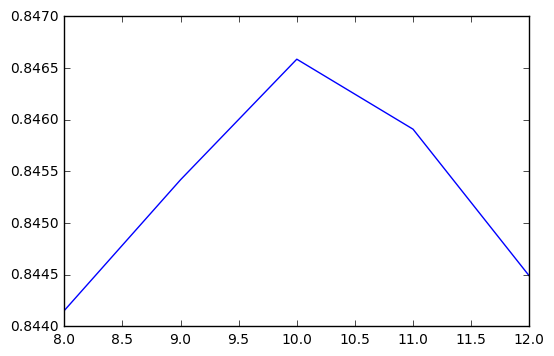

In [18]:
%%time
depths = range(8, 13)
scores = []

for depth in depths:
    pred = out_of_fold_prediction(RandomForestClassifier(max_depth=depth,
                                                         n_estimators=100,
                                                        n_jobs=-1,
                                                        random_state=1),
                                 X_train_fe, y_train, skf.split(X_train_fe, y_train))
    scores.append(roc_auc_score(y_train, pred))

plot(depths, scores)
print(max(scores), depths[np.argmax(scores)])

**У RandomForest на CV - 0.84659, на оставленной выборке - 0.84039.**

In [16]:
%%time
forest = RandomForestClassifier(max_depth=10, n_estimators=500, 
                                n_jobs=-1,
                                random_state=1)
forest.fit(X_train_fe, y_train)
forest_oof_pred = out_of_fold_prediction(forest, 
                                         X_train_fe, y_train, skf.split(X_train_fe, y_train))
forest_ho_pred = forest.predict_proba(X_holdout_fe)[:,1]
print(roc_auc_score(y_holdout, forest_ho_pred))

0.84038795659
CPU times: user 4min 23s, sys: 3.57 s, total: 4min 27s
Wall time: 1min 25s


**Out-of-Fold-прогноз Xgboost с исходными признаками. Подбираем глубину деревьев. (Можно было еще настраивать learning_rate).**

(0.84770010517114269, 3)
CPU times: user 1min 19s, sys: 587 ms, total: 1min 20s
Wall time: 1min 21s


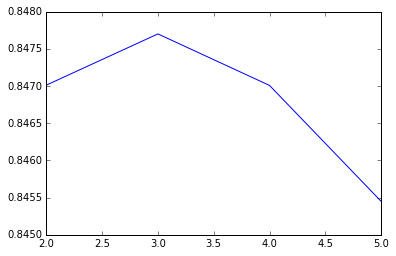

In [17]:
%%time

depths = range(2, 6)
scores = []

for depth in depths:
    pred = out_of_fold_prediction(XGBClassifier(max_depth=depth,
                                               n_estimators=150),
                                 X_train, y_train, skf.split(X_train, y_train))
    scores.append(roc_auc_score(y_train, pred))

plot(depths, scores)
print(max(scores), depths[np.argmax(scores)])

**У Xgboost на CV - 0.8477, на оставленной выборке - 0.84203.**

In [18]:
%%time
xgb = XGBClassifier(max_depth=3, n_estimators=150)
xgb.fit(X_train, y_train)
xgb_oof_pred = out_of_fold_prediction(xgb,
                                 X_train, y_train, skf.split(X_train, y_train))
xgb_ho_pred = xgb.predict_proba(X_holdout)[:,1]
print(roc_auc_score(y_holdout, xgb_ho_pred))

0.842033036971
CPU times: user 22.6 s, sys: 222 ms, total: 22.8 s
Wall time: 23.1 s


### Смешивание Xgboost и RF

In [19]:
def best_linear_mix(target, pred1, pred2):
    best_auc, best_w1 = 0, 0
    for w1 in np.linspace(0, 1, 20):
        curr_pred = w1 * pred1 + (1 - w1) * pred2
        curr_auc = roc_auc_score(target, curr_pred)
        if curr_auc > best_auc:
            best_auc = curr_auc
            best_pred = curr_pred
            best_w1 = w1
    return best_auc, best_pred, best_w1

In [20]:
best_auc, best_pred, best_w1 = best_linear_mix(y_train, 
                                        xgb_oof_pred, forest_oof_pred)

In [21]:
best_auc, best_w1

(0.84926020257836921, 0.57894736842105265)

In [22]:
xgb_rf_ho_pred = best_w1 * xgb_ho_pred + (1 - best_w1) * forest_ho_pred

**У смеси на CV - 0.84926, на оставленной выборке - 0.84352.**

In [23]:
print(roc_auc_score(y_holdout, xgb_rf_ho_pred))

0.843517749205


### Прогноз для тестовой выборки

In [24]:
%%time
forest = RandomForestClassifier(max_depth=10, n_estimators=500, 
                                n_jobs=-1,
                                random_state=1)
forest.fit(train_df_fe, y)
rf_pred = forest.predict_proba(test_df_fe)[:,1]

CPU times: user 1min 28s, sys: 2.86 s, total: 1min 31s
Wall time: 28.4 s


In [25]:
%%time
xgb = XGBClassifier(max_depth=3, n_estimators=150)
xgb.fit(train_df, y)
xgb_pred = xgb.predict_proba(test_df)[:,1]

CPU times: user 6.8 s, sys: 96.7 ms, total: 6.89 s
Wall time: 7.03 s


In [26]:
final_pred = 0.5789 * xgb_pred + (1 - 0.5789) * rf_pred

**Запишем прогнозы в файл.**

In [27]:
def write_to_submission_file(predicted_labels, out_file,
                             target='Delinquent90', index_label="client_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(75000, 
                                predicted_labels.shape[0] + 75000),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [28]:
write_to_submission_file(xgb_pred, 
                '../../output/credit_scoring_xgb_pred.csv') # LB .854 
write_to_submission_file(rf_pred, 
                '../../output/credit_scoring_rf_pred.csv') # LB .85145
write_to_submission_file(final_pred, 
                '../../output/credit_scoring_xgb_rf_mix.csv') # LB .85457

**Есть все основания полагать, что смесь Xgboost и RF сработала лучше, чем алгоритмы по отдельности.**

         ________________________________________________
         |  ROC AUC    | Out-of-fold | Holdout |   LB   |
         |_____________|_____________|_________|________|
         | XGBoost     | .8477       | .84203  | .854   |
         | RF          | .84659      | .84039  | .85145 |
         | XGB + RF    | .84926      | .84352  | .85457 |
         |_____________|_____________|_________|________|